# DIA Object Deduplication

Author: Melissa

Last updated: 2025-01-14 by Sandro

In [1]:
import hats
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm

import lsdb
import pandas as pd

from hats.catalog import PartitionInfo
from hats.io import paths
from hats.io.parquet_metadata import write_parquet_metadata
from hats.catalog import TableProperties
from pathlib import Path

from datetime import datetime, timezone

/sdf/home/s/stavar/.local/lib/python3.11/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - DiaObject'}>)

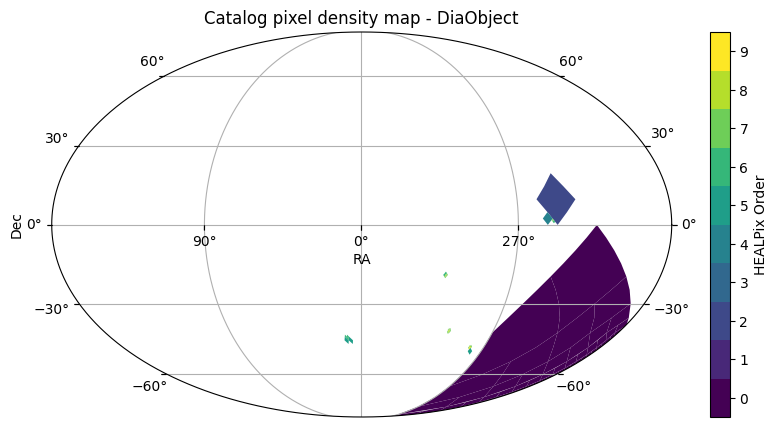

In [2]:
hats_dir = "/sdf/data/rubin/shared/lsdb_commissioning/or4_dia/hats"
catalog = hats.read_hats(f"{hats_dir}/DiaObject")
catalog.plot_pixels()

In [3]:
catalog.catalog_info.total_rows

12222552

We know from querying like:

```
        SELECT count(distinct("diaObjectId"))
        FROM DiaObject
```

That there are only 1_791_959 distinct objects, so around 85% of objects are duplicates. We could either use LSDB (or just some vanilla numpy/pyarrow operations), to de-duplicate the object table. There is a column named `validityStart`, which we can use to filter out the older records of the object.

In [4]:
# All objects have valid timestamps for validityStart
lsdb_catalog = lsdb.read_hats(f"{hats_dir}/DiaObject")
validities = lsdb_catalog["validityStart"].compute()
validity_timestamps = pd.to_datetime(validities, errors="coerce")
print(validity_timestamps)
assert validity_timestamps.notna().all()

_healpix_29
2192018945801658396    2024-10-18 23:29:03.653000+00:00
2192018945801658396    2024-10-18 23:29:03.653000+00:00
2192018946168077471    2024-10-18 23:29:03.653000+00:00
2192018946168077471    2024-10-18 23:29:03.653000+00:00
2192018946875656030    2024-10-18 23:29:03.653000+00:00
                                     ...               
3430724221009401319    2024-10-20 00:25:36.246000+00:00
3430724221689439233    2024-10-19 03:32:33.922000+00:00
3430724227220385675    2024-10-20 00:25:36.246000+00:00
3430724227220385675    2024-10-20 00:25:36.246000+00:00
3430724227563038642    2024-10-19 03:32:33.922000+00:00
Name: validityStart, Length: 12222552, dtype: timestamp[ns, tz=UTC][pyarrow]


In [3]:
# Check that it works for a single pixel
for target_pixel in catalog.get_healpix_pixels()[0:1]:
    file_path = hats.io.pixel_catalog_file(catalog.catalog_base_dir, target_pixel)
    df = pq.ParquetFile(file_path).read().to_pandas()

    # Get the unique objects and their counts
    unique, counts = np.unique(df["diaObjectId"].to_numpy(), return_counts=True)
    print("Unique: ", unique)
    print("Counts: ", counts)

    # e.g. object 3068394109505896450 has count of 7
    repeated_row_indices = np.where(df["diaObjectId"].to_numpy() == 3068394109505896450)[0]
    print("Repeated row indices: ", repeated_row_indices)
    repeated_rows = df.iloc[repeated_row_indices]
    print("Repeated rows: ", repeated_rows[["diaObjectId", "validityStart"]])

    # Group by diaObjectId and get the row with the latest validtyStart
    row_for_each_obj = df.groupby("diaObjectId")["validityStart"].idxmax()
    print("Object row: ", row_for_each_obj)
    filtered_df = df.iloc[row_for_each_obj]
    row = filtered_df[filtered_df["diaObjectId"] == 3068394109505896450]
    print("Selected row: ", row[["diaObjectId", "validityStart"]])

    print("Num objs before: ", len(df))
    print("Num uniques: ", len(unique))
    print("Num objs after: ", len(filtered_df))

Unique:  [3068394109505896449 3068394109505896450 3068394109505896451 ...
 3068394237314729226 3068394237314729229 3068394237314729230]
Counts:  [1 7 4 ... 1 1 1]
Repeated row indices:  [188932 188933 188934 188935 188936 188937 188938]
Repeated rows:                  diaObjectId                    validityStart
188932  3068394109505896450 2024-10-18 21:13:26.990000+00:00
188933  3068394109505896450 2024-10-18 21:52:40.541000+00:00
188934  3068394109505896450 2024-10-18 21:32:29.029000+00:00
188935  3068394109505896450 2024-10-18 21:51:00.698000+00:00
188936  3068394109505896450 2024-10-18 21:36:18.929000+00:00
188937  3068394109505896450 2024-10-18 21:35:35.432000+00:00
188938  3068394109505896450 2024-10-18 21:33:14.885000+00:00
Object row:  diaObjectId
3068394109505896449    188931
3068394109505896450    188933
3068394109505896451    188911
3068394109505896452    187623
3068394109505896453    188915
                        ...  
3068394237314729218    185609
3068394237314729220    1

And now actually apply it to the whole catalog:

In [5]:
out_dir = "/sdf/data/rubin/shared/lsdb_commissioning/or4_dia/hats"

In [7]:
input_rows = 0
output_rows = 0

for target_pixel in tqdm(catalog.get_healpix_pixels()):
    file_path = hats.io.pixel_catalog_file(catalog.catalog_base_dir, target_pixel)
    df = pq.ParquetFile(file_path).read().to_pandas()
    input_rows += len(df)

    # Group by diaObjectId and get the row with the latest validtyStart
    row_for_each_obj = df.groupby("diaObjectId")["validityStart"].idxmax()
    filtered_df = df.iloc[row_for_each_obj]
    output_rows += len(filtered_df)

    # Quick check: make sure we have the same number of uniques after filtering
    uniques = np.unique(df["diaObjectId"].to_numpy())
    assert len(uniques) == len(filtered_df)
    
    destination_dir = hats.io.pixel_directory(f"{out_dir}/DiaObject-dedup/", target_pixel.order, target_pixel.pixel)
    hats.io.file_io.make_directory(destination_dir, exist_ok=True)
    out_path = hats.io.pixel_catalog_file(f"{out_dir}/DiaObject-dedup/", target_pixel)
    filtered_df.to_parquet(out_path)

  0%|                                                                                                                           | 0/103 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:21<00:00,  4.80it/s]


In [8]:
print("input_rows", input_rows)
print("output_rows", output_rows)

input_rows 12222552
output_rows 1408117


In [9]:
destination_path = Path(f"{out_dir}/DiaObject-dedup/")

parquet_rows = write_parquet_metadata(destination_path)
print("parquet_rows", parquet_rows)
assert parquet_rows == output_rows

# Read partition info from _metadata and write to partition_info.csv
partition_info = PartitionInfo.read_from_dir(destination_path)
partition_info_file = paths.get_partition_info_pointer(destination_path)
partition_info.write_to_file(partition_info_file)

now = datetime.now(tz=timezone.utc)

catalog_info = TableProperties(
    catalog_name="DiaObject",
    total_rows=parquet_rows,
    hats_order=9,
    hats_builder = "Sandro Campos",
    hats_creation_date= now.strftime("%Y-%m-%dT%H:%M%Z"),
    catalog_type="object",
    ra_column="ra",
    dec_column="dec",
)
catalog_info.to_properties_file(destination_path)

parquet_rows 1408117


/sdf/home/s/stavar/.local/lib/python3.11/site-packages/hats/catalog/partition_info.py:135: UserWarning: Reading partitions from parquet metadata. This is typically slow.
  warnings.warn("Reading partitions from parquet metadata. This is typically slow.")
